<a href="https://colab.research.google.com/github/harshrupendrasingh/micrograd/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [119]:
class Value:
  def __init__(self, data, _children = (), _op = '', label = '') -> None:
    self.data = data
    self._prev = set(_children)
    self.grad = 0.0
    self._backward = lambda: None
    self._op = _op
    self.label = label


  def __repr__(self) -> str:
    return f"Value({self.data})"


  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out


  def __rmul__(self, other):
    return self * other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out


  def __truediv__(self, other):
    return self * other**-1


  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * self.data**(other-1) * out.grad
    out._backward = _backward
    return out


  def __neg__(self):
    return self * -1


  def __sub__(self, other):
    return self + (-other)


  def __radd__(self, other):
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/ (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
      self.grad += (1-t**2) * out.grad
    out._backward = _backward
    return out


  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    def _backward():
      self.grad += out.data * out.data
    out._backward = _backward
    return out


  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1.0

    for node in reversed(topo):
      node._backward()

In [120]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [121]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.7, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [122]:
o.backward()

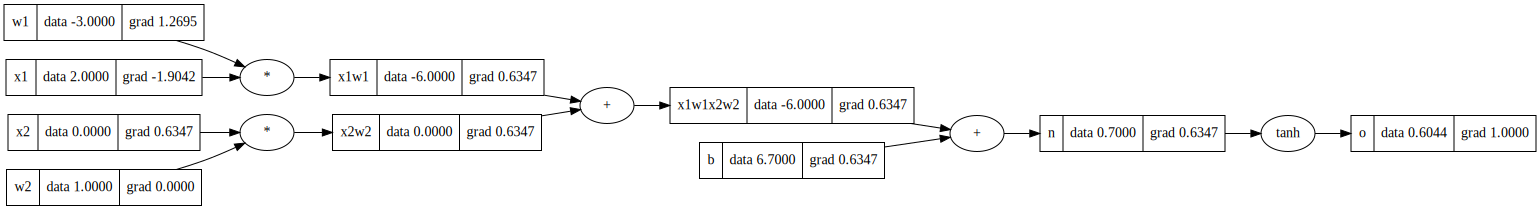

In [123]:
draw_dot(o)

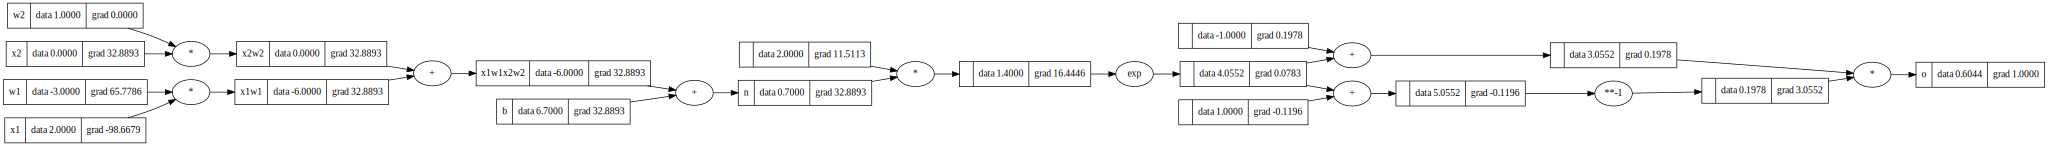

In [124]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.7, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e-1) / (e +1)
o.label = 'o'
o.backward()
draw_dot(o)

In [125]:
import torch

x1 = torch.tensor([2.0]).double()            ; x1.requires_grad = True
x2 = torch.tensor([0.0]).double()            ; x2.requires_grad = True

w1 = torch.tensor([-3.0]).double()            ; w1.requires_grad = True
w2 = torch.tensor([1.0]).double()            ; w2.requires_grad = True

b = torch.tensor([6.7]).double()            ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print(x1.grad.item())
print(x2.grad.item())
print(w1.grad.item())
print(w2.grad.item())

0.6043676560501806
-1.9042192089612318
0.6347397363204106
1.2694794726408212
0.0


In [126]:

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
n.parameters()

[Value(0.2541100417475084),
 Value(0.6722550791992954),
 Value(0.32521881764925054),
 Value(0.24791294834675304),
 Value(-0.7845761136649214),
 Value(-0.013313276570230848),
 Value(-0.9325753655483979),
 Value(0.751691960116684),
 Value(0.715267911538856),
 Value(-0.44309435583880274),
 Value(0.3929907667183157),
 Value(-0.7104707643436443),
 Value(-0.6224863018483227),
 Value(0.10212966440279692),
 Value(0.538496372538408),
 Value(-0.9278757640781399),
 Value(0.8048994559027698),
 Value(-0.09204762257798271),
 Value(-0.1737410009353595),
 Value(0.9660601738276964),
 Value(-0.7960001972001056),
 Value(-0.5792457483173341),
 Value(-0.11272130759587351),
 Value(0.05622357675839473),
 Value(0.6663717920731032),
 Value(0.7122370419690554),
 Value(-0.8314738543775935),
 Value(0.22972435632036192),
 Value(0.39745466563864396),
 Value(0.38498404447316026),
 Value(0.9569249496273442),
 Value(0.2190463280275261),
 Value(0.8223851575346603),
 Value(-0.5664147611365673),
 Value(-0.534102031651176

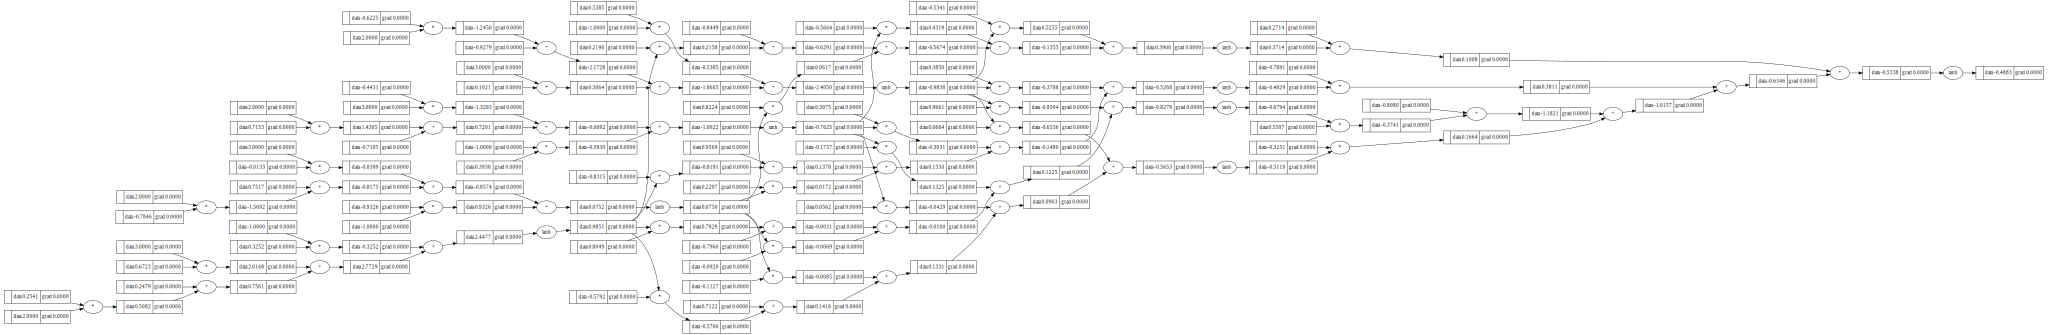

In [127]:
draw_dot(n(x))

In [131]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 5.0],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [132]:
for k in range(20):
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  for p in n.parameters():
    p.data += -0.01 * p.grad
  print(k, loss.data)

0 2.0626194285725288e-06
1 2.0626063281358383e-06
2 2.062593227958974e-06
3 2.062580128042505e-06
4 2.0625670283862087e-06
5 2.0625539289897725e-06
6 2.062540829853874e-06
7 2.0625277309777006e-06
8 2.062514632361716e-06
9 2.0625015340059724e-06
10 2.0624884359102523e-06
11 2.062475338074732e-06
12 2.0624622404989485e-06
13 2.062449143183725e-06
14 2.062436046128559e-06
15 2.0624229493328294e-06
16 2.062409852797478e-06
17 2.062396756522341e-06
18 2.062383660507085e-06
19 2.0623705647518488e-06
